<a href="https://colab.research.google.com/github/tarangga/Coursera/blob/main/Coursera_Understanding_and_Applying_Text_Embeddings_with_VertexAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
! pip install google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.5 MB/s eta 0:00:00


# Basic

In [33]:
import os
from google.colab import userdata
import numpy as np

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = userdata.get('gcp-credentials')


In [17]:
from vertexai.language_models import TextEmbeddingModel
import vertexai
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

In [18]:
embedding = embedding_model.get_embeddings(
    ["life", 'hidup'])

In [20]:
cosine_similarity([embedding[0].values], [embedding[1].values])

array([[0.61408103]])

In [60]:
texts = [
    "anak anak bermain di lapangan",
    "permainan lapangan ini untuk anak anak",
    'banyak anak sedang memakan kue dan kismis',
    'penjual membuat permen untuk anak anak',
    'karyawan sedang mengalami kemacetan',
    'seorang karyawan sangat kelelahan',
    'ibu rumah tangga saat ini sedang bingung memikirkan tagihan rumah tangga',
    'bayi sedang menangis sangan keras',
    'bayi sedang menangis sangan keras, membuat tetangga merasa terganggu',
    'terdengar suara bayi menangis dari rumah sebelah',
]

In [61]:
emb_res = embedding_model.get_embeddings(texts)

In [62]:
emb_arr = np.array([emb.values for emb in emb_res])

In [63]:
from sklearn.decomposition import PCA
pca = PCA(2)
emb_pca = pca.fit_transform(emb_arr)

In [64]:
import plotly.express as px
import pandas as pd

In [65]:
df = pd.DataFrame({'x':emb_pca[:,0], 'y':emb_pca[:,1], 'v': texts})

In [70]:
fig = px.scatter(df, x='x', y='y', hover_data=['v'])
fig.show()

In [82]:
words_map = dict()

for t, v in zip(texts, emb_arr):
  words_map[t] = [v]

In [83]:
import itertools

comb_arr = list(itertools.product(texts, texts))

In [88]:
df = pd.DataFrame(comb_arr, columns=['t1', 't2'])
df['score'] = df.apply(lambda x: cosine_similarity(
    words_map.get(x['t1']), words_map.get(x['t2'])
)[0][0], axis=1)

In [92]:
px.imshow(pd.pivot_table(df, values='score', index='t2', columns='t1'))

# Combine with Machine Learning

In [111]:
df = pd.read_csv('so_database_app.csv')
df.head()

,input_text,output_text,category
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python
1,Passing parameter to function while multithrea...,<p>Try this and note the difference:</p>\n<pre...,python
2,How do we test a specific method written in a ...,"<p>Duplicate of <a href=""https://stackoverflow...",python
3,how can i remove the black bg color of an imag...,<p>The alpha channel &quot;disappears&quot; be...,python
4,How to extract each sheet within an Excel file...,<p>You need to specify the <code>index</code> ...,python


In [112]:
df.shape

(2000, 3)

In [113]:
def encode_texts_to_embeddings(sentences):
    try:
        embeddings = embedding_model.get_embeddings(sentences)
        return [embedding.values for embedding in embeddings]
    except Exception:
        return [None for _ in range(len(sentences))]

In [114]:
from time import sleep
from tqdm import tqdm
questions = df['input_text'].tolist()
batch_size = 10
emb_resp = []
for i in tqdm(range(0, len(questions), batch_size)):
    sent = questions[i : i + batch_size]
    emb_resp = emb_resp + encode_texts_to_embeddings(sent)
    sleep(2)

100%|██████████| 200/200 [07:06<00:00,  2.13s/it]


In [115]:
df['emb_question'] = emb_resp

In [118]:
clean_df = df.dropna()

In [155]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [156]:
X = np.asarray(clean_df['emb_question'].tolist())

In [157]:
X.shape

(570, 768)

In [162]:
distortions = []
max_cls = 30
for c in range(2, max_cls):
  kmeans = KMeans(c)
  kmeans.fit(X)
  distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

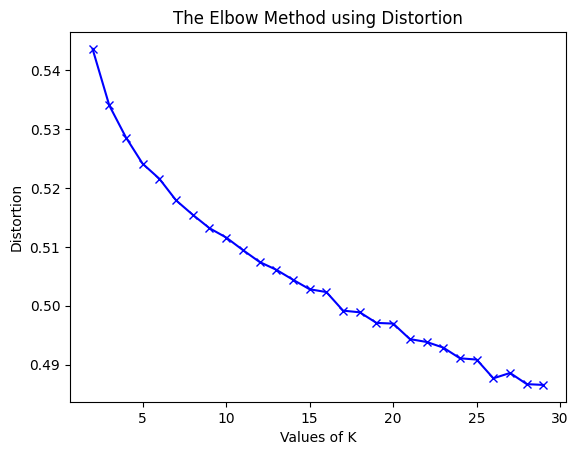

In [164]:
import matplotlib.pyplot as plt
plt.plot(range(2, max_cls), distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


In [171]:
kmeans = KMeans(15)
kmeans.fit(X)
clean_df['label'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-171-4a8d521b53e4>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [173]:
PCA_model = PCA(n_components=2)
PCA_model.fit(X)
new_values = PCA_model.transform(X)

In [175]:
clean_df['x'] = new_values[:, 0]
clean_df['y'] = new_values[:, 1]

<ipython-input-175-50237232d5d0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-175-50237232d5d0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [176]:
clean_df.head(1)

,input_text,output_text,category,emb_question,label,x,y
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python,"[-0.03561034053564072, -0.0025025042705237865,...",11,-0.231694,-0.208372


In [179]:
fig = px.scatter(clean_df, x='x', y='y', hover_data=['input_text', 'category'] , color='label')
fig.show()